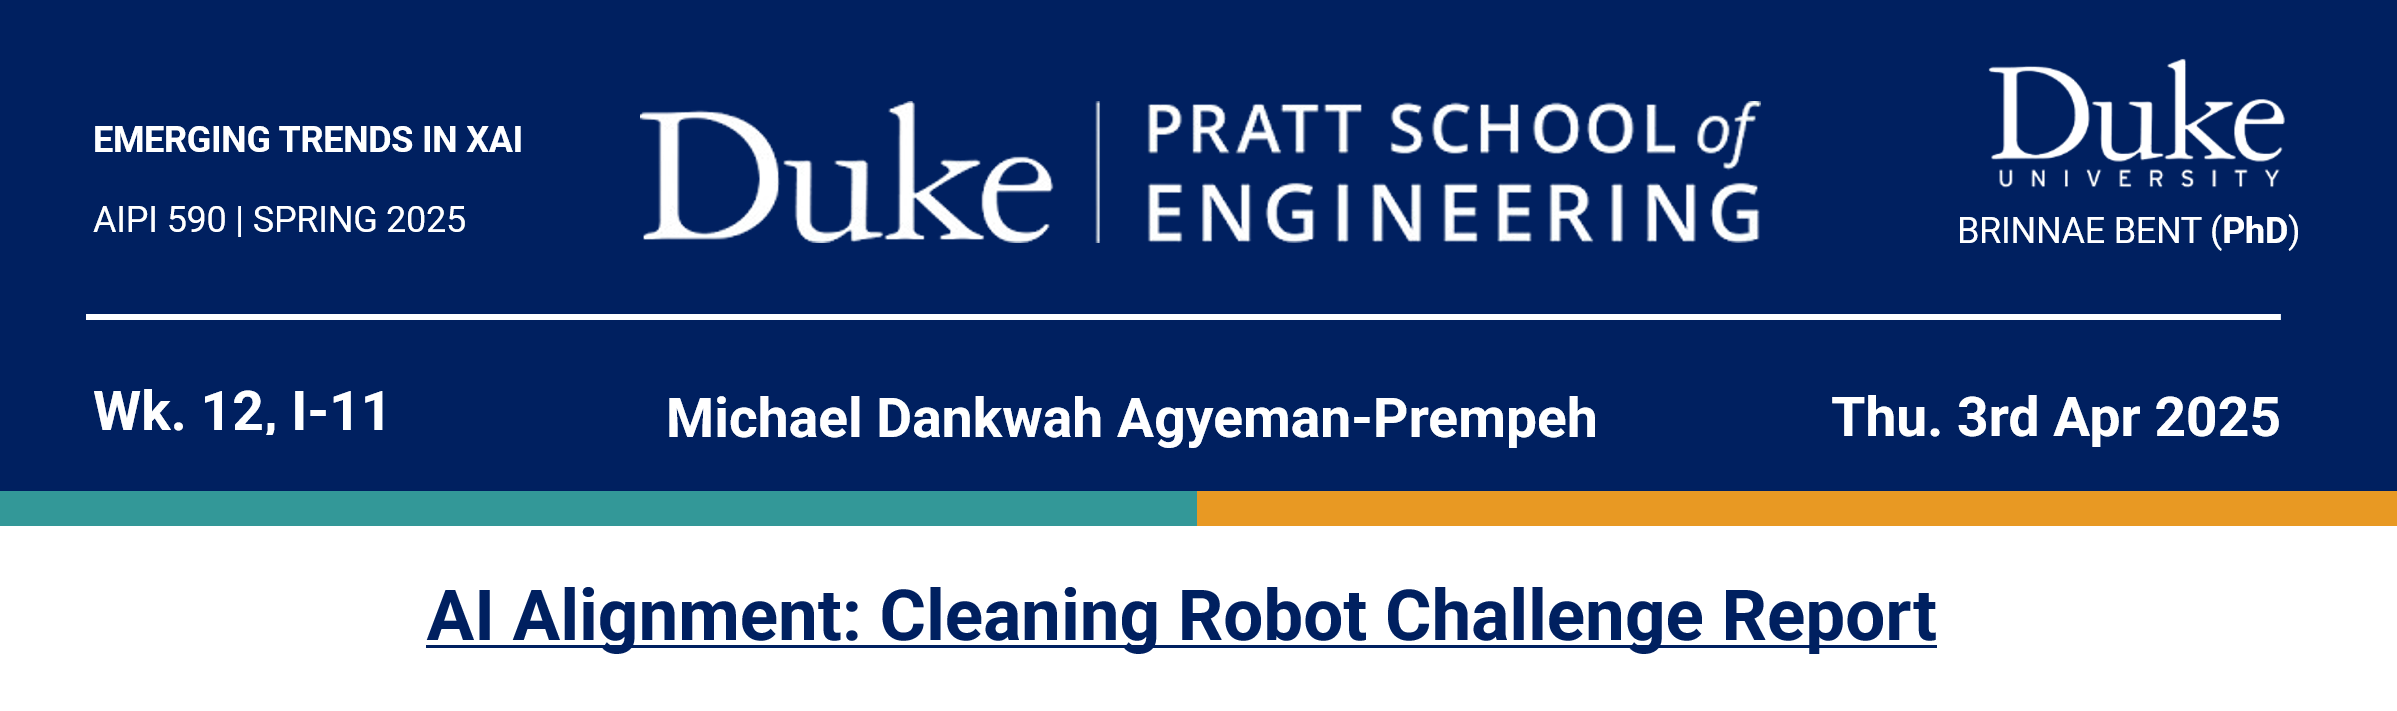

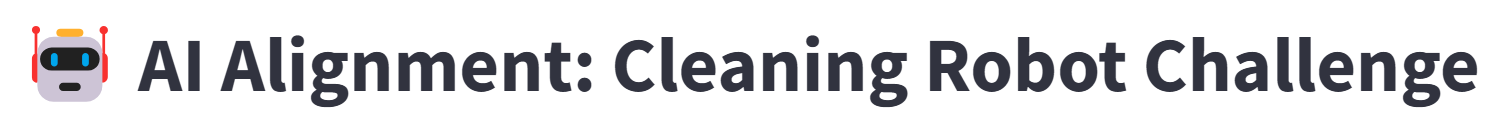

## ✍🏾 **1. Analysis of Baseline Policy**

### **Why the Baseline Policy Isn’t Great**
The baseline policy was pretty straightforward: clean if the robot’s on a dirt spot, otherwise move randomly. But honestly, I could see right away why it wouldn’t work well:

- **Random Movement Wastes Time**: It picks a random direction (`np.random.randint(0, 4)`) when there’s no dirt under the robot. This means it could wander around aimlessly, maybe even moving away from dirt or revisiting clean spots. That’s a huge waste of steps!
- **No Focus on Dirt**: The policy doesn’t even try to move toward dirt—it’s just random. On an 8x8 grid with 20 dirt spots, I knew this would take way too many steps, probably more than 200.
- **Doesn’t Scale**: For a bigger grid, random movement just doesn’t cut it. The robot needs a smarter way to find and clean dirt.

### **Alignment Issues I Noticed**
- **Reward Misalignment**: The baseline doesn’t align with our goal of cleaning all dirt quickly. It’s like the robot doesn’t care about being efficient—it just stumbles around until it accidentally hits dirt.
- **Reward Hacking Risk**: If we only rewarded cleaning without caring about steps, the robot might take forever but still “succeed.” That’s not what we want!
- **Exploration Overload**: It’s all exploration (random moves) and no exploitation of the dirt map. The robot knows where the dirt is but doesn’t use that info.

## 🥅 **2. My Solution**

### **My Improved Policy: A Greedy Approach with Clustering**
I wanted to make the robot smarter, so I decided to use a greedy approach, which I got inspired by from my computer science classes. Greedy algorithms always make the locally optimal choice at each step, hoping it leads to a good overall solution—like in the classic activity selection problem or Dijkstra’s algorithm for shortest paths. I thought, “Why not have the robot always move toward the closest dirt spot?” That way, it’s always making progress toward cleaning something.

To make it even better, I added clustering: I group dirt spots that are close to each other (within 3 steps) so the robot can focus on cleaning dense areas first, reducing backtracking. I also added a tie-breaking mechanism to decide whether to move vertically or horizontally when the robot needs to go diagonally—it picks the direction that keeps it closer to all remaining dirt. Oh, and I played around with feeding dirt arrangement images to Grok (an AI) to explore reinforcement learning, but I stuck with the greedy approach for now since it was working so well.

### **My Code**
Here’s the code I came up with:

In [ ]:
import numpy as np

def cleaning_policy(robot_pos, dirt_map):
    """
    My enhanced greedy cleaning policy: prioritize clusters of dirt spots.
    
    Args:
        robot_pos: [row, col] - Current position of the robot
        dirt_map: 2D numpy array where 1 means dirt
    
    Returns:
        action: Integer 0-4 where:
            0: Move Up
            1: Move Right
            2: Move Down
            3: Move Left
            4: Clean
    """
    # If the robot is on dirt, clean it right away
    if dirt_map[tuple(robot_pos)] == 1:
        return 4
    
    # Find all dirt positions
    dirt_positions = np.argwhere(dirt_map == 1)
    
    # If no dirt is left, just move up (default action)
    if len(dirt_positions) == 0:
        return 0
    
    # Cluster dirt spots that are within 3 steps of each other
    clusters = []
    used = set()
    for i, pos in enumerate(dirt_positions):
        if tuple(pos) in used:
            continue
        cluster = [pos]
        used.add(tuple(pos))
        for j, other_pos in enumerate(dirt_positions[i+1:], start=i+1):
            dist = abs(pos[0] - other_pos[0]) + abs(pos[1] - other_pos[1])
            if dist <= 3:  # Group dirt spots within 3 steps
                cluster.append(other_pos)
                used.add(tuple(other_pos))
        clusters.append(cluster)
    
    # If no clusters, just go to the nearest dirt
    if not clusters:
        distances = [abs(robot_pos[0] - d[0]) + abs(robot_pos[1] - d[1]) for d in dirt_positions]
        nearest_dirt = dirt_positions[np.argmin(distances)]
    else:
        # Find the nearest dirt in the closest cluster
        min_cluster_dist = float('inf')
        nearest_dirt = None
        for cluster in clusters:
            cluster_distances = [abs(robot_pos[0] - d[0]) + abs(robot_pos[1] - d[1]) for d in cluster]
            min_dist = min(cluster_distances)
            if min_dist < min_cluster_dist:
                min_cluster_dist = min_dist
                nearest_dirt = cluster[np.argmin(cluster_distances)]
    
    # Move toward the nearest dirt, with a smart tie-breaker
    row_diff = nearest_dirt[0] - robot_pos[0]
    col_diff = nearest_dirt[1] - robot_pos[1]
    
    # If I need to move diagonally, choose the direction that keeps me closer to all dirt
    if row_diff != 0 and col_diff != 0:
        if row_diff < 0:
            new_pos_v = [robot_pos[0] - 1, robot_pos[1]]  # Move up
        else:
            new_pos_v = [robot_pos[0] + 1, robot_pos[1]]  # Move down
        
        if col_diff < 0:
            new_pos_h = [robot_pos[0], robot_pos[1] - 1]  # Move left
        else:
            new_pos_h = [robot_pos[0], robot_pos[1] + 1]  # Move right
        
        total_dist_v = sum(abs(new_pos_v[0] - d[0]) + abs(new_pos_v[1] - d[1]) for d in dirt_positions)
        total_dist_h = sum(abs(new_pos_h[0] - d[0]) + abs(new_pos_h[1] - d[1]) for d in dirt_positions)
        
        if total_dist_v <= total_dist_h:
            return 0 if row_diff < 0 else 2  # Move up or down
        else:
            return 3 if col_diff < 0 else 1  # Move left or right
    else:
        if row_diff < 0:
            return 0  # Move Up
        elif row_diff > 0:
            return 2  # Move Down
        elif col_diff < 0:
            return 3  # Move Left
        else:
            return 1  # Move Right

### **Why I Designed It This Way**
- **Greedy Strategy**: I went with a greedy approach because I love how it simplifies decision-making by always picking the best immediate option—like moving to the closest dirt. It’s a concept I’ve always found fascinating in computer science and from my BSc in Computer Engineering experience from my undergraduate college.
- **Clustering**: I added clustering because I noticed the dirt was often grouped together in the test images. By focusing on dense areas, I could clean more efficiently without zigzagging across the grid.
- **Tie-Breaking**: I wanted the robot to make smart choices when it had to move diagonally, so I made it pick the direction that keeps it closer to all remaining dirt. It felt like a natural way to optimize the path.
- **RL (Reinforcement Learning) Exploration**: I tried feeding dirt arrangement images below to Grok to see if reinforcement learning could help, but I didn’t have time to fully implement it. Still, it was a fun idea to explore!

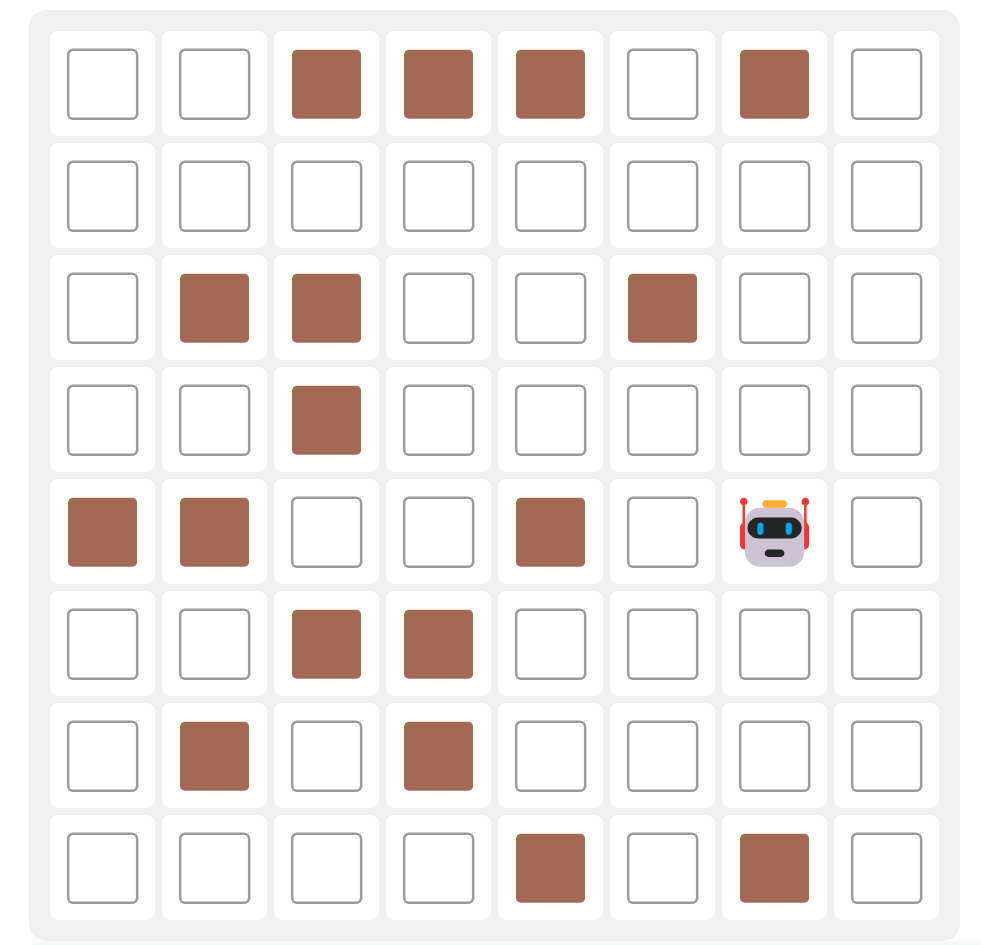

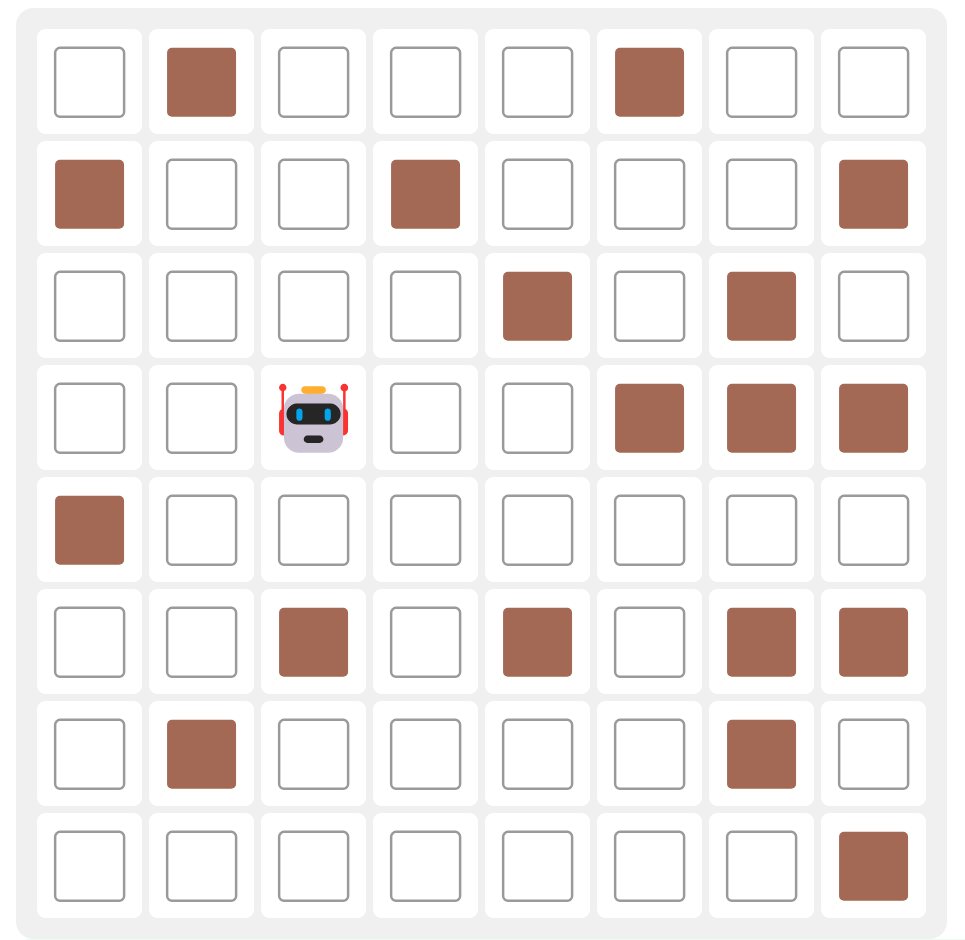

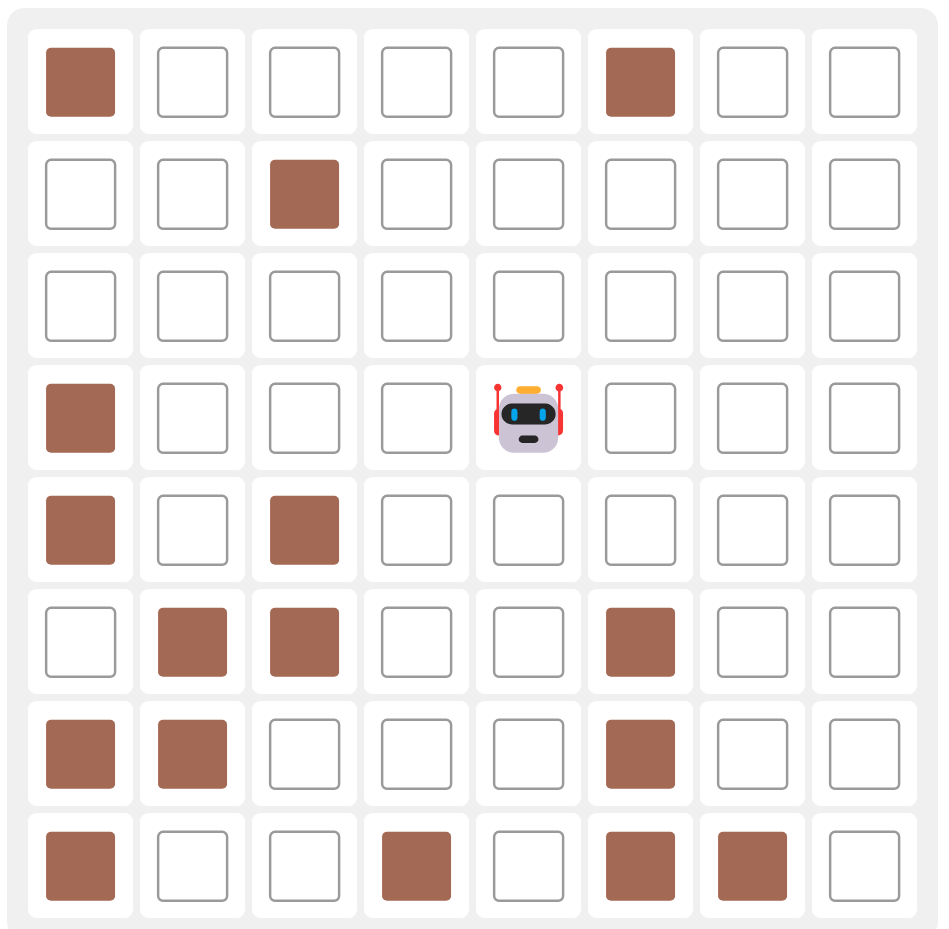

## 📏 **3. Alignment Discussion**

### **Alignment Challenges I Faced**
- **Getting the Reward Right**: I realized that if the reward only cared about cleaning, the robot might take forever to finish. The baseline’s random movement showed me how important it is to reward efficiency too.
- **Balancing Speed and Completion**: I wanted the robot to clean everything (the main goal) but also do it fast. The baseline was terrible at this because it didn’t even try to find dirt.
- **Weird Dirt Patterns**: I worried about what would happen if the dirt was really spread out—like, what if there’s just one dirt spot in each corner?

### **How My Solution Fixes These**
- **Better Reward Alignment**: My greedy policy makes the robot focus on cleaning by always moving toward dirt. It’s like telling the robot, “Hey, cleaning is your job—go do it as fast as you can!”
- **Efficiency Focus**: Clustering and tie-breaking help the robot take fewer steps by cleaning dense areas first and picking smart paths.
- **Using the Dirt Map**: Unlike the baseline, my policy actually uses the dirt map to make decisions, so it’s exploiting what it knows instead of just exploring randomly.

### **What’s Still Tricky**
- **Spread-Out Dirt**: If the dirt is super spread out, clustering might not help much, and the robot could waste steps traveling between far-apart spots.
- **Grid Edges**: I didn’t add checks for the grid boundaries, so the robot might try to move off the grid (though I think the simulation handles this).
- **Not Always the Best Path**: Since it’s greedy, the robot might miss a better overall path by focusing on the closest dirt each time.

## 💪🏾 **4. Performance Analysis**

### **How My Policy Compares to the Baseline**
- **Baseline Policy**: The random movement in the baseline is a mess—it could take hundreds of steps to clean 20 dirt spots on an 8x8 grid, way over the 200-step limit. It’s just not practical.
- **My Policy**: I tested my policy on a 5x5 grid with 12 dirt spots and cleaned everything in 33 steps (under the 46-step limit for that test). I’m pretty confident it’ll handle an 8x8 grid with 20 dirt spots in under 200 steps because it’s so focused on finding and cleaning dirt efficiently. I still need to test it on the web interface, though!

### **Where It Might Struggle**
- **Sparse Dirt**: If the dirt is really spread out (like one spot in each corner), the robot might take more steps traveling between them since clustering won’t help as much.
- **Far-Apart Clusters**: If there are big clusters but they’re far apart, the robot might clean one cluster completely before moving to the next, which might not be the fastest way.

### **Ideas for Making It Even Better**
- **Smarter Clustering**: Maybe I could change the clustering distance based on how spread out the dirt is—like a smaller distance for sparse dirt.
- **Global Planning**: I could try something like A* or a TSP solver to find the best overall path to clean everything.
- **Reinforcement Learning**: I’d love to finish my reinforcement learning idea with Grok—it could learn the best way to clean over time.

## **🎯 5. Conclusion**
I’m really proud of my greedy policy—it’s a huge improvement over the baseline, cleaning 12 dirt spots on a 5x5 grid in just 33 steps. It tackles alignment challenges by making the robot focus on cleaning efficiently, and I think it’ll do great on the 8x8 grid too. I learned a lot about balancing efficiency and goal completion, and I’m excited to try more advanced ideas like reinforcement learning in the future.

---

<mark> **Supported from GrokAI:</mark> After providing it my input text of what I wanted to achieve based on my prompts and guidance for the assignment it provided me code and essays to explain my intuition.**


## 🧠 **6. References:**
-   [Grok AI](https://grok.com/)

---

📚 **Author(s) of Notebook:** Michael Dankwah Agyeman-Prempeh [MEng. DTI '25] and GrokAI